<a href="https://colab.research.google.com/github/daje0601/pandas_study/blob/main/2.%20%ED%82%A4%EC%9B%8C%EB%93%9C_%EB%B6%84%EC%84%9D(Keyword_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 키워드 분석(Keyword Analysis)

* 핵심어(keyword)란 텍스트 자료의 중요한 내용을 압축적으로 제시하는 단어 또는 문구
* 핵심어 분석이란 불용어 제거와 어간추출 및 형태소 분석 등의 자연어 처리를 시행한 후 텍스트에서 많이 등장하는 형태소의 등장 빈도를 분석함으로써 핵심어를 추출   
* 특정 텍스트 자료에 많이 나타나는 형태소가 그 텍스트 주제를 표출할 가능성이 높다는 가정에 기초  
* 물론 빈도 분석에서 영어의 전치사나 한국어의 조사와 같이 의미를 별로 담고 있지 않은 불용어는 제외하는 것이 좋음
* 키워드 분석은 텍스트의 주제 추정, 텍스트 유사도, 검색 엔진의 검색 결과 우선 순위 측정 등 다양하게 사용될 수 있음

## 한글 폰트 설정

* 실행 후 런타임 재시작 필요

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

%config InlineBackend.figure_format="retina"

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm 
fontpath = "/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc("font", family="NanumBarunGothic")
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
!set -x \ 
!pip install konlpy
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

## 네이버 영화 리뷰 데이터

* 키워드 분석에는 네이버 영화 리뷰 데이터를 사용
* 데이터 다운로드: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt

In [19]:
import urllib.request

raw = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt").readlines()
print(raw[:5])

[b'id\tdocument\tlabel\n', b'8112052\t\xec\x96\xb4\xeb\xa6\xb4\xeb\x95\x8c\xeb\xb3\xb4\xea\xb3\xa0 \xec\xa7\x80\xea\xb8\x88\xeb\x8b\xa4\xec\x8b\x9c\xeb\xb4\x90\xeb\x8f\x84 \xec\x9e\xac\xeb\xb0\x8c\xec\x96\xb4\xec\x9a\x94\xe3\x85\x8b\xe3\x85\x8b\t1\n', b'8132799\t\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb8\xec\x9d\x84 \xeb\xb0\xb0\xec\x9a\xb0\xeb\x8a\x94 \xed\x95\x99\xec\x83\x9d\xec\x9c\xbc\xeb\xa1\x9c, \xec\x99\xb8\xea\xb5\xad\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb4\xeb\x84\x88\xec\x99\x80 \xea\xb7\xb8\xeb\x93\xa4\xec\x9d\xb4 \xec\x9d\xbc\xea\xb5\xb0 \xec\xa0\x84\xed\x86\xb5\xec\x9d\x84 \xed\x86\xb5\xed\x95\xb4 \xeb\xb0\x9c\xec\xa0\x84\xed\x95\xb4\xea\xb0\x80\xeb\x8a\x94 \xeb\xac\xb8\xed\x99\x94\xec\x82\xb0\xec\x97\x85\xec\x9d\xb4 \xeb\xb6\x80\xeb\x9f\xac\xec\x9b\xa0\xeb\x8a\x94\xeb\x8d\xb0. \xec\x82\xac\xec\x8b\xa4 \xec\x9a\xb0\xeb\xa6\xac\xeb\x82\x98\xeb\x9d\xbc\xec\x97\x90\xec\x84\x9c\xeb\x8f\x84 \xea\xb7\xb8 \xec\x96\xb4\xeb\xa0\xa4\xec\x9a\xb4\xec\x8b\x9c\xec\xa0\x88\xec\x97\x90 \xeb\x81\x9d

한국어 이다보니 위와 같이 출력이 된다. 

* 데이터를 확인해보면 모두 바이트로 이루어져 있으며, 리뷰 외의 다른 데이터도 존재
* 데이터를 문자열로 변환하고 리뷰만 추출

In [20]:
raw = [x.decode() for x in raw[1:]]

reviews = []
for i in raw :
  reviews.append(i.split('\t')[1])

print(reviews[:3])

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ', '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.', '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.']


## 형태소 분석을 이용한 명사 추출


* 형태소 분석기 Mecab으로 명사만 추출
* 형태소 분석기를 통해 조사와 접속사 제거

In [22]:
from konlpy.tag import Mecab

tagger = Mecab()
nouns = [] 
for review in reviews:
  # 명사만 tagger에 통과시켜서 review에서 데이터를 가져오는 작업
  for noun in tagger.nouns(review):
    nouns.append(noun)

nouns[:4]

['때', '디자인', '학생', '외국']

### 불용어(Stopwords) 사전 만들기

* 형태소 분석을 통해 조사, 접속사 등의 제거 가능
* 하지만 한국어는 명사에서도 상당히 많은 불필요한 단어들이 포함
* 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어 제거 필요
* 불용어 예: `전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것`
* 빈도가 너무 커서 분석에 방해되는 단어도 제거 필요 (예: `영화`)


In [23]:
stop_words = "영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 그"
stop_words = stop_words.split(" ")
print(stop_words)

['영화', '전', '난', '일', '걸', '뭐', '줄', '만', '건', '분', '개', '끝', '잼', '이거', '번', '중', '듯', '때', '게', '내', '말', '나', '수', '거', '점', '것']


### 불용어를 제외하여 형태소 분석 수행

* 한글 텍스트에 대해서 형태소 분석 수행
* 분석으로 추출하는 명사 중에서 불용어에 포함되지 않은 텍스트만 추출하여 저장

In [25]:
nouns = [] 
for review in reviews:
  # 명사만 tagger에 통과시켜서 review에서 데이터를 가져오는 작업
  for noun in tagger.nouns(review):
    # 단, 가져온 명사가 stop_words에 포홤되어 있지 않을 때만 append를 진행함 
    if noun not in stop_words:
      nouns.append(noun)

nouns[:10]

['디자인', '학생', '외국', '디자이너', '그', '전통', '발전', '문화', '산업', '우리']

## 단어 빈도수 측정

* 단어 빈도수 측정에는 `collections` 라이브러리의 `Counter` 함수를 이용
* `collections` 라이브러리는 내장 라이브러리로 별도 설치가 필요없음
* `counter`를 이용하면 각 단어와 각 단어의 빈도 수를 딕셔너리로 편리하게 생성 가능

In [56]:
from collections import Counter

nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(100))
top_nouns

{'ㄷ': 1791,
 '가슴': 1817,
 '가족': 1401,
 '감독': 5629,
 '감동': 6489,
 '개봉': 1248,
 '건지': 1397,
 '결말': 2066,
 '공감': 1288,
 '공포': 2048,
 '굿': 2110,
 '그': 1410,
 '극장': 1290,
 '급': 1632,
 '기대': 3465,
 '기분': 1241,
 '기억': 2364,
 '나라': 1409,
 '남자': 2078,
 '내용': 5731,
 '년': 4936,
 '눈': 1484,
 '눈물': 1704,
 '느낌': 1950,
 '대박': 1495,
 '대사': 1263,
 '데': 1707,
 '돈': 2980,
 '드라마': 6896,
 '때문': 2371,
 '마음': 2128,
 '마지막': 3647,
 '매력': 1832,
 '명작': 2685,
 '모습': 1364,
 '몰입': 1453,
 '뭔가': 1361,
 '밋': 1820,
 '반전': 1868,
 '배우': 5893,
 '부분': 1246,
 '뿐': 1429,
 '사람': 6742,
 '사랑': 4741,
 '생각': 6943,
 '소재': 1999,
 '속': 1738,
 '수준': 1864,
 '스토리': 7163,
 '시간': 5320,
 '시리즈': 1380,
 '실망': 1557,
 '쓰레기': 4585,
 '씨': 1902,
 '아이': 1749,
 '애': 2730,
 '액션': 3568,
 '여운': 1386,
 '여자': 2678,
 '연기': 9175,
 '연기력': 1387,
 '연출': 2376,
 '우리': 2531,
 '원작': 1705,
 '음악': 1852,
 '이': 1560,
 '이건': 3650,
 '이걸': 1264,
 '이게': 3046,
 '이상': 2676,
 '이야기': 2947,
 '이해': 2745,
 '인간': 1811,
 '인생': 2060,
 '일본': 1878,
 '자체': 1558,
 '작품': 3985,
 '장면':

## 단어 빈도 시각화

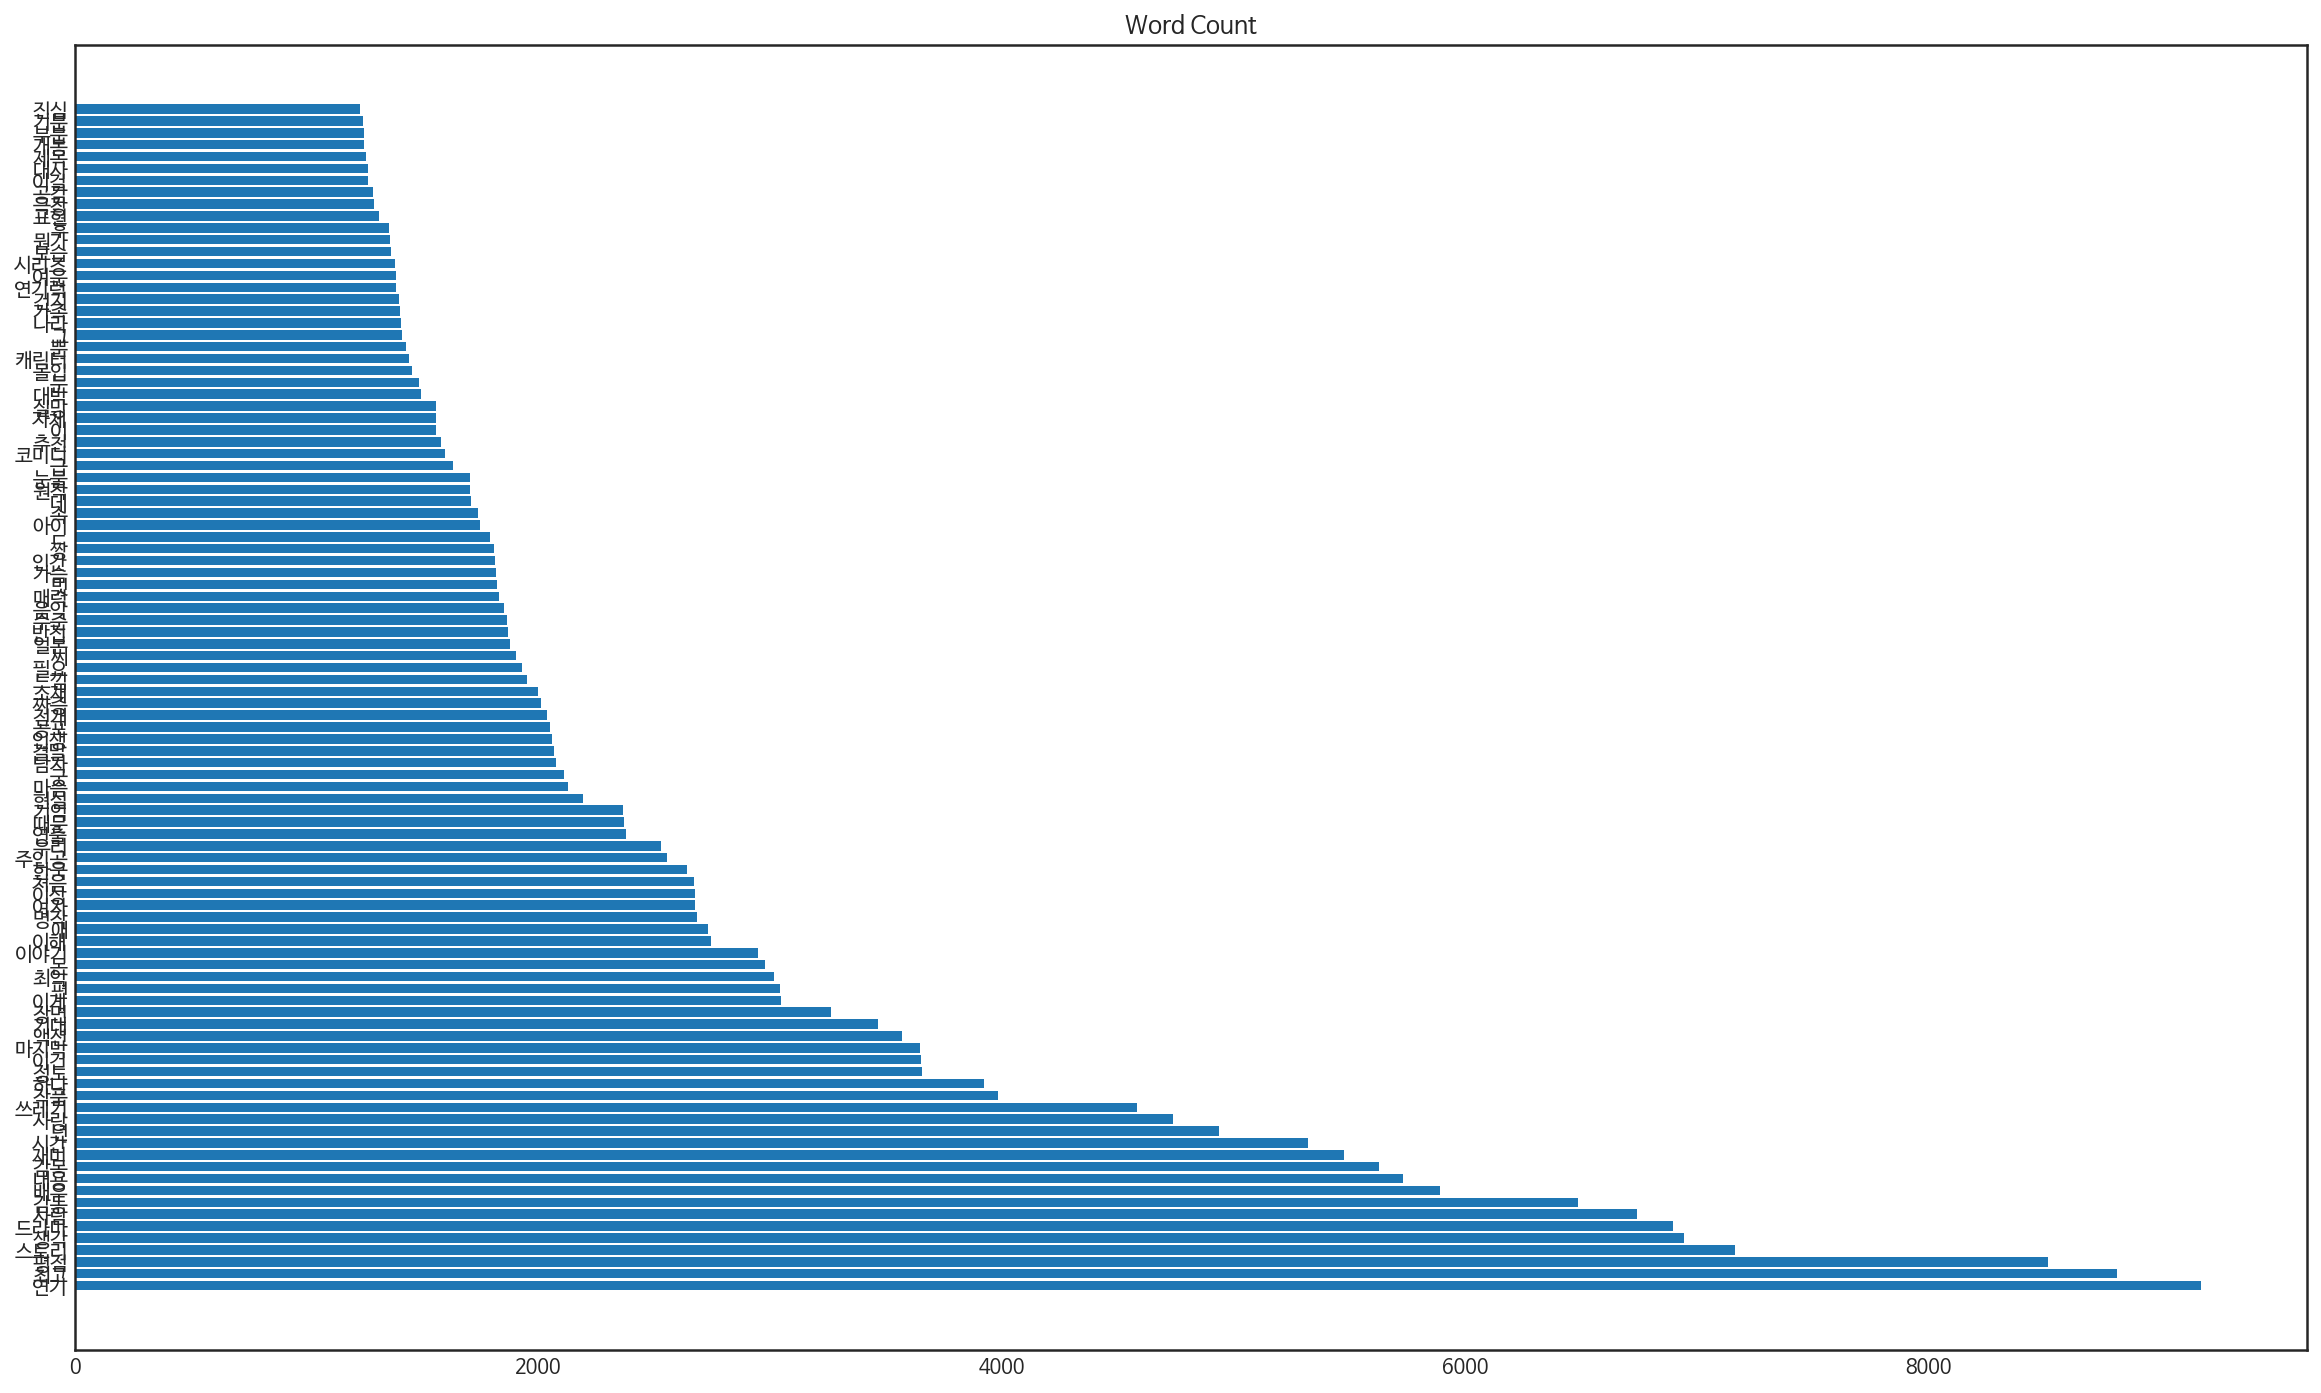

In [59]:
import numpy as np

y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(20, 12))
plt.barh(y_pos, top_nouns.values())
plt.title("Word Count")
plt.yticks(y_pos, top_nouns.keys())
plt.show()

## 워드클라우드(WordCloud)

* 텍스트에 담겨있는 여러 형태소들의 등장 빈도를 가장 직관적으로 시각화하는 방법
* 텍스트에 등장하는 단어를 그 등장 빈도에 따라 서로 크기가 다르게 구름 형태로 표현함으로써, 단어의 빈도 수를 한번에 알 수 있음  
* 최근에 많은 서비스들이 어떤 핵심어가 많이 등장했는가를 워드클라우드 형식으로 시각화
* 빈도 수만을 시각적으로 표현한 것이기 때문에, 단어들 사이의 연관성이나 의미 구조 등을 분석하는 데는 한계가 있음

* 파이썬에서 워드 클라우드를 시각화하기 위해 `matplotlib` 라이브러리와 `WordCloud` 라이브러리를 `import` 해서 사용
* `WordCloud` 라이브러리는 `pip install wordcloud` 명령어를 통해 설치 필요

In [49]:
!pip install wordcloud

* WordCloud를 이용해 객체를 생성해주고,
`generate_from_frequencies()` 함수로 빈도 수에 따라 워드클라우드 생성

In [60]:
from wordcloud import WordCloud

# 한글이 포함되어 있기 때문에 font_path를 필수로 지정해주어야한다. 
wc = WordCloud(background_color="white", font_path="./font/NanumBarunGothic.ttf")

# wordcloud 객체 생성 
wc.generate_from_frequencies(top_nouns)

* 워드클라우드를 시각화할 때는 이미지 시각화 함수인 `imshow()` 함수를 사용해야 함

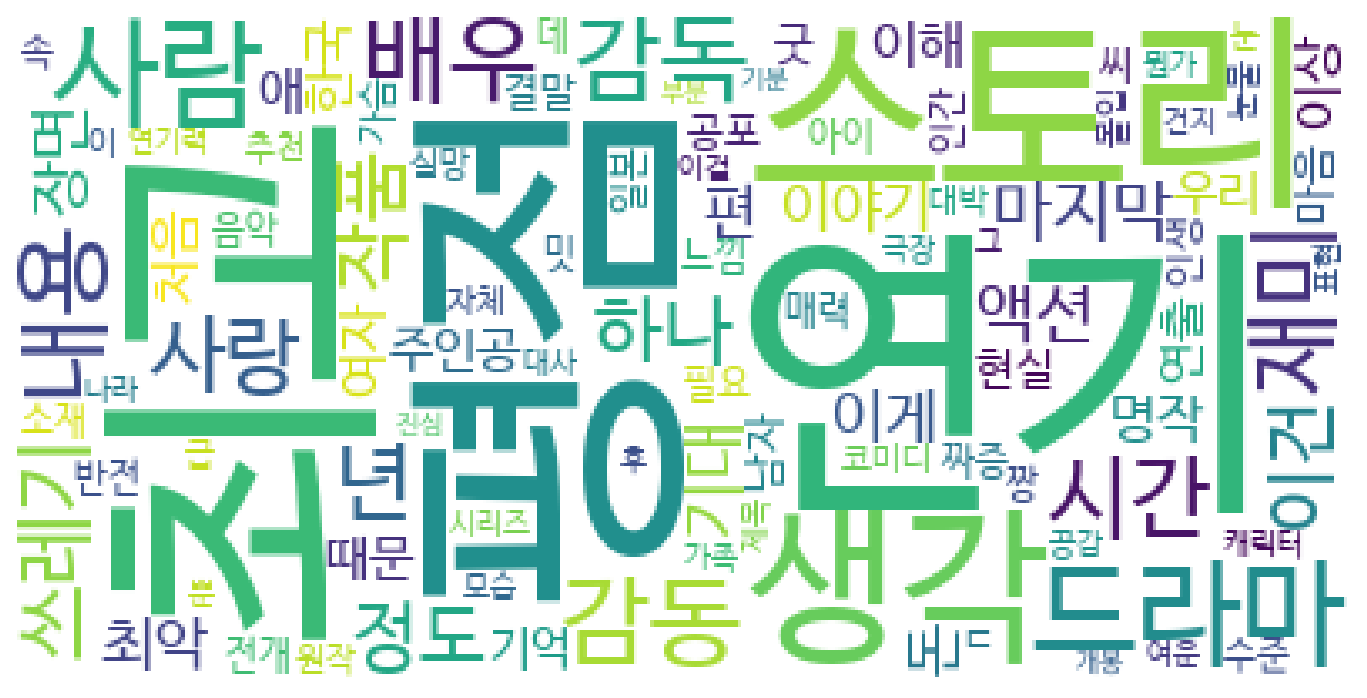

In [61]:
figure= plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis("off")
ax.imshow(wc)
plt.show()

## squarify 트리맵 시각화

* `squarify`는 트리맵 생성을 지원해주는 파이썬 라이브러리
* `squarify` 라이브러리를 이용해 키워드와 키워드 빈도 수를 트리맵으로 나타냄   

In [62]:
!pip install squarify

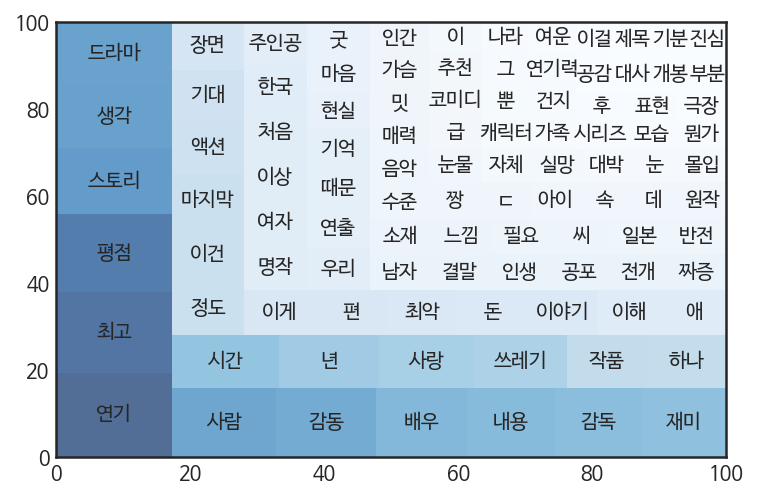

In [64]:
import squarify

#출력하기 전 카운트된 숫자들을 normalize를 해줘야한다. 
norm = mpl.colors.Normalize(vmin=min(top_nouns.values()),
                            vmax=max(top_nouns.values()))
# 색깔 지정 
# 카운트 된 숫자에 따라서 색상의 진해지는 정도를 결정해주는 코드 
colors = [mpl.cm.Blues(norm(value)) for value in top_nouns.values()]

squarify.plot(label=top_nouns.keys(),
              sizes=top_nouns.values(),
              color=colors,
              alpha=.7);